<div style="text-align: right">INFO 6105 Data Science Eng Methods and Tools, Lecture 7 Day 2</div>
<div style="text-align: right">Dino Konstantopoulos, 23 February 2023</div>

In this notebook, we review and contrast compurational sttistics with classical statistics' Hypothesis testing. We also visit 2 pretty cool libraries: `best` and `pingouin`.

# Compare Computational statistics, Classical Statistics Hypothesis Testing

There's a python library that does the mcmc simulations *automatically*! It's called `best`.
```
pip install best
```

In [1]:
%matplotlib inline

# basic datascience/data manipulation libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import scipy.stats as stats

# graphs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# formulat interface to statsmodels (standard linear models)
import statsmodels.formula.api as smf

# hate these things
import warnings
warnings.filterwarnings("ignore")

# 1. Computational Statistics (MCMC) Review
Let's *cheat* and create some data instead of finding it somewhere, and then use `pymc3` to try to recover the corresponding parameters *computationally*.

To introduce model definition, fitting and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes $Y$ as normally-distributed observations with an expected mean value $\mu$ that is a linear function of two predictor variables $X_1$ and $X_2$.

$$Y \approx \mathcal{N}(\mu, \sigma^2)$$

$$\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$$

where $\alpha$ is the intercept, and $\beta_1$ is the coefficient for covariate $X_1$, $\beta_2$ is the coefficient for covariate $X_2$, while $\sigma$ represents the observation error. 

Since we are constructing a Bayesian model, we must assign a **prior** distribution to the unknown variables in the model. 

We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to **weak information** regarding the true parameter values. 

We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$:

$$\alpha \approx \mathcal{N}(0, 100)$$

$$\beta_i \approx \mathcal{N}(0, 100)$$

$$\sigma \approx |\mathcal{N}(0, 1)|$$

In [2]:
# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Let's plot it:

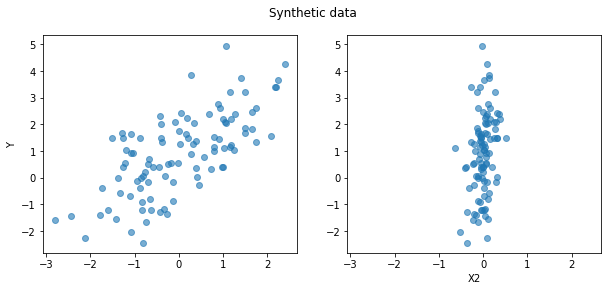

In [10]:
#fig, (ax1, ax2) = plt.subplots(2) #vertically stacked
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(10, 4)) #horizontally stacked
fig.suptitle('Synthetic data')
ax1.scatter(X1, Y, alpha=0.6)
ax2.scatter(X2, Y, alpha=0.6)

ax1.set_ylabel("Y")
ax2.set_xlabel("X1")
ax2.set_xlabel("X2");

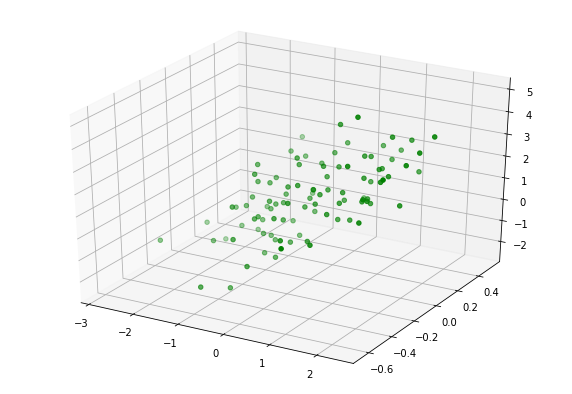

In [5]:
from mpl_toolkits import mplot3d
 
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(X1, X2, Y, color = "green")

Now let's see if we can **model** `Y` as a *dependent variable* depending on *independent variables* `X1` ad `X2`.

With **computational statistics**!

In [6]:
from pymc3 import Model, Normal, HalfNormal

basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

The first three statements in the context manager:
```
alpha = Normal('alpha', mu=0, sigma=10)
beta = Normal('beta', mu=0, sigma=10, shape=2)
sigma = HalfNormal('sigma', sigma=1)
```

create stochastic random variables with Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations $\sigma$.

These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

We call the Normal constructor to create a random variable to use as a normal prior. The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. 

The remaining required arguments for a stochastic object are the parameters, in this case mu, the mean, and sd, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as `Beta`, `Exponential`, `Gamma`, `Binomial` and many others, are available in PyMC3.

Having defined the priors, the next statement creates the expected value mu of the outcomes, specifying the linear relationship:
```
mu = alpha + beta[0]*X1 + beta[1]*X2
```

This creates a deterministic random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, mu is just the sum of the intercept alpha and the two products of the coefficients in beta and the predictor variables, whatever their values may be.

PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like sum, sin, exp and linear algebra functions like dot (for inner product) and inv (for inverse) are also provided.

The final line of the model, defines Y_obs, the sampling distribution of the outcomes in the dataset:
```
Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)
```

This is a special case of a stochastic variable that we call an observed stochastic, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its observed argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a numpy.ndarray or pandas.DataFrame object.

To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a step method object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s step_methods submodule contains the following samplers: NUTS, Metropolis, Slice, HamiltonianMC, and BinaryMetropolis. These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Binary variables will be assigned to BinaryMetropolis

- Discrete variables will be assigned to Metropolis

- Continuous variables will be assigned to NUTS

In [14]:
import pymc3 as pm

with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:14<00:00, 285.60draws/s] 


The sample function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a Trace object containing the samples collected, in the order they were collected. 

The trace object can be queried in a similar way to a dict containing a map from variable names to numpy.arrays. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the alpha variable as follows:

In [15]:
trace["alpha"][-5:]

array([1.02972552, 0.72574242, 1.13507898, 1.09788536, 0.73054609])

### Posterior analysis
PyMC3’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named `ArviZ`. A simple posterior plot can be created using plot_trace.

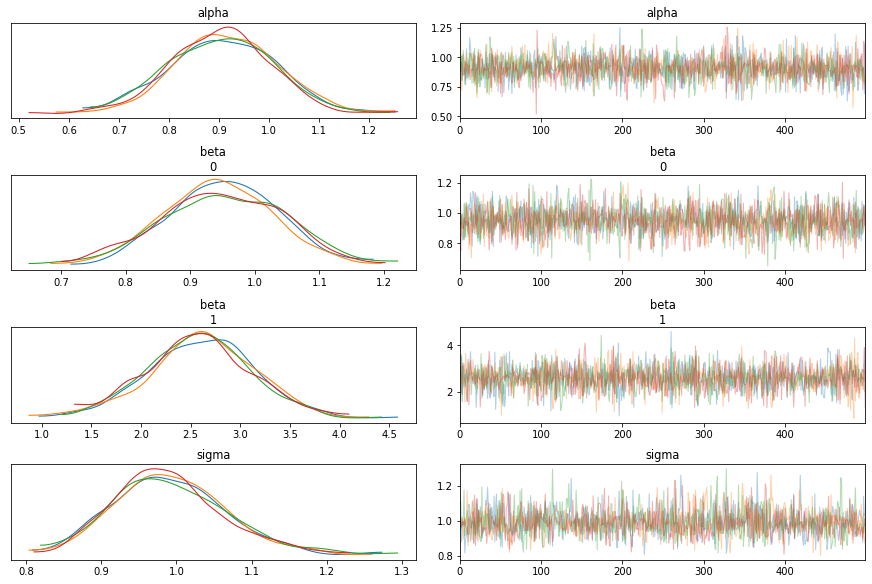

In [16]:
import arviz as az 

with basic_model:
    az.plot_trace(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [17]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.91,0.10,0.72,1.10,0.00,0.00,2829.09,2668.11,2822.27,1553.08,1.0
beta[0],0.95,0.09,0.77,1.10,0.00,0.00,2299.89,2265.38,2286.83,1574.93,1.0
beta[1],2.59,0.53,1.57,3.57,0.01,0.01,3106.20,3106.20,3101.11,1599.59,1.0
sigma,0.99,0.08,0.85,1.13,0.00,0.00,1923.19,1889.57,1975.13,1633.46,1.0


Did we recover our original parameters?

*Yes, we did!*

Now, this tells us what we should believe about $\alpha$ and $\beta_i$ *after* we see the data, but it doesn’t tell us what the dependent column $Y$ will look like. 

In other words, how can we generate simulated $Y$ data if, like professor says, "*we can now throw away the data becausee we have the model!*". 

For that, we need the posterior predictive distribution, which we can get by running `sample_posterior_predictive`:

In [18]:
with basic_model:
    post_pred = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:17<00:00, 113.02it/s]


The result is similar to the trace we got from sample, but it contains a sample of $Y$'s  rather than $\alpha$ and $\beta_i$:

In [19]:
post_pred

{'Y_obs': array([[-0.37444251,  2.36245798,  3.40257228, ..., -2.39773897,
          1.32273418,  0.63028849],
        [-0.33532199,  0.71466361,  2.91524255, ...,  0.6946978 ,
          1.75986561,  1.28615394],
        [-0.2712645 , -0.89149103,  2.16947045, ..., -1.47017347,
          0.74711038,  0.04980135],
        ...,
        [-0.26799255,  0.52560591,  2.17106324, ..., -1.3961072 ,
          0.77114507, -0.6261471 ],
        [ 0.22016578,  0.15310518,  2.44895817, ..., -1.07721956,
          1.68391625,  0.01981294],
        [ 0.15804892, -0.87758706,  0.9375126 , ..., -0.06689402,
          1.90118251,  0.54812786]])}

This is the mean of $Y$ we should expect:

In [21]:
post_pred['Y_obs'].mean()

0.9239242643867956

And this is the standard deviation of $Y$ we should expect:

In [22]:
post_pred['Y_obs'].var()

2.402125302085089

How different are these predictions from our original data?

In [23]:
Y.mean(), Y.var()

(0.9222099812958149, 2.31748152178224)

Not bad, right?

And what do the simulated $Y$s look like compare to the real observattions?

In [25]:
post_pred['Y_obs'].shape, Y.shape

((2000, 100), (100,))

Hey, why are my simulated $Y$s not the same shape as my observations!?

That's because when you sampled from the posterior predictive, you didn't jsut generate *one* simulation, you generated 2,000 of them!

So any one of these is an appropriate simulation that we can compare against the original observations.

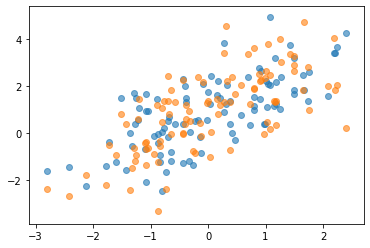

In [26]:
plt.scatter(X1, Y, alpha=0.6)
plt.scatter(X1, post_pred['Y_obs'][0, :], alpha=0.6)

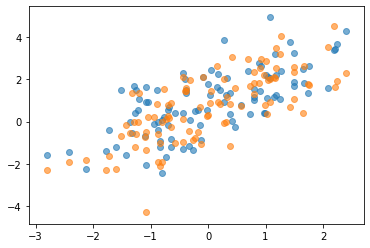

In [27]:
plt.scatter(X1, Y, alpha=0.6)
plt.scatter(X1, post_pred['Y_obs'][1000, :], alpha=0.6)

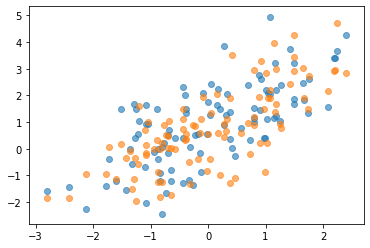

In [28]:
plt.scatter(X1, Y, alpha=0.6)
plt.scatter(X1, post_pred['Y_obs'][1999, :], alpha=0.6)

That is what it means to **predict** a dataset. 

Once you have a **model**, everything else is easy!

In this case, we built ourselves a **generative** model, one that allows us to predict *all* observations.

But we could have also built a **discriminative** model, one that predicts whether somthing happens or not, without generating an entire (simulated) distribution.

So, the "**statistics**" of the simulated data and the observed data are the same. What does that mean? The mean is the same, the standard deviation is the same, the shape of the histograms are the same, etc.

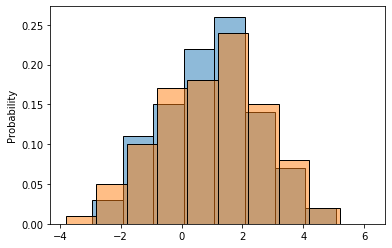

In [31]:
import seaborn as sns
sns.histplot(Y, stat='probability', discrete=True,
                 alpha=0.5, label='original')
sns.histplot(post_pred['Y_obs'][0, :], stat='probability', discrete=True,
                 alpha=0.5, label='posterior pred', color='C1')

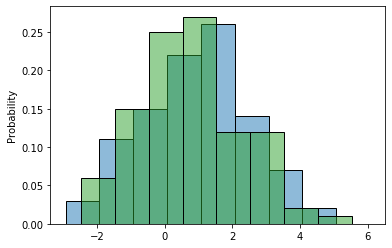

In [32]:
sns.histplot(Y, stat='probability', discrete=True,
                 alpha=0.5, label='original')
sns.histplot(post_pred['Y_obs'][1999, :], stat='probability', discrete=True,
                 alpha=0.5, label='posterior pred', color='C2')

# 2. Computational Sports Analytics
Ok, well, what we did above was just plotting points in 3D space.

A bit *boring*, right?

Let's make this more exciting by competing Porsche against Mercedes.

We'll have the teams race each other once at [Florano](https://en.wikipedia.org/wiki/Fiorano_Circuit) and once at [Nurburgring](https://www.racingcircuits.info/europe/germany/nurburgring.html).

We'll tally the wins for each time, and then we'll build a predictive model.

Ferrari wins easily at Florano 50 laps to 31 and at Nurburgring eekes out a victory with 25 laps to 20. 

Let's compute the posterior distribution for each team based on these outcomes.

In [40]:
alpha = 4.6
beta = 1.9

with pm.Model() as f1_model:
    mu_ferrari = pm.Gamma('mu_ferrari', alpha, beta)
    mu_mercedes = pm.Gamma('mu_mercedes', alpha, beta)
    laps_ferrari = pm.Poisson('laps_ferrari', mu_ferrari, observed=[50, 25])
    laps_mercedes = pm.Poisson('laps_mercedes', mu_mercedes, observed=[31, 20])

We use Poisson distributions because of course, we counting integer lap wins.

We have previously studied F1 historical results, which is what allowed us to model lap wins expectations as a Gamma function. That is the subject for *another* notebook.

Now, let's build a model for Mercedes vs Ferrari:

In [41]:
with f1_model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_mercedes, mu_ferrari]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 974.85draws/s] 


Here are the posterior distributions:

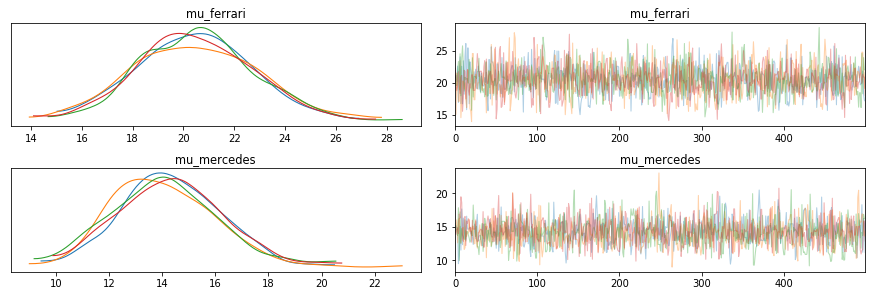

In [42]:
import arviz as az

with f1_model:
    az.plot_trace(trace);

The posterior distributions for mu_ferrari and mu_mercedes:

In [43]:
mu_ferrari = trace['mu_ferrari']
mu_mercedes = trace['mu_mercedes']
mu_ferrari.mean(), mu_mercedes.mean()

(20.490494698398077, 14.2048881866286)

In other words, I expect Ferrari to beat Mercedes 4 to 3.

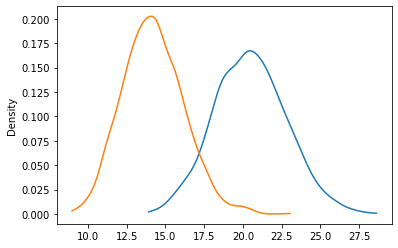

In [44]:
sns.kdeplot(mu_ferrari, cut=0, label='mu_ferrari posterior')
sns.kdeplot(mu_mercedes, cut=0, label='mu_mercedes posterior')

Here’s the probability of superiority:

In [45]:
(mu_ferrari > mu_mercedes).mean()

0.982

In other words, there's a 98% probability that Ferrari is faster than Mercedes!

But that does not mean that Ferrai will necessarily win the next lap! That is the essence of statistics.

To compute the probability that Ferrari wins the next lap, we can use sample_posterior_predictive to generate predictions.

In [46]:
with f1_model:
    post_pred = pm.sample_posterior_predictive(trace)

100%|██████████| 2000/2000 [00:02<00:00, 955.70it/s] 


In [47]:
post_pred

{'laps_ferrari': array([[28, 18],
        [19, 18],
        [20, 21],
        ...,
        [23, 23],
        [21, 27],
        [19, 15]]),
 'laps_mercedes': array([[17, 21],
        [11, 13],
        [16,  9],
        ...,
        [11,  9],
        [12, 14],
        [13, 14]])}

It would be fairer to compare both teams at their respective homes, something we *can* do with a model, but cannot in the real world!

In [50]:
lap_wins_ferrari_florano = [f for f,n in post_pred['laps_ferrari']]
lap_wins_mercedes_nurburgring = [n for f,n in post_pred['laps_mercedes']]

Let's plot histograms:

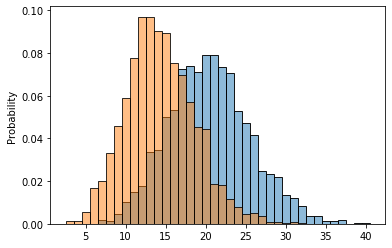

In [51]:
sns.histplot(lap_wins_ferrari_florano, stat='probability', discrete=True,
                 alpha=0.5, label='Ferrari')
sns.histplot(lap_wins_mercedes_nurburgring, stat='probability', discrete=True, color='C1',
                 alpha=0.5, label='Mercedes')

Ferrari (in blue) wins more laps than Mercedes (in orange). 

Ferrari wins around 20 laps for every 14 won by Mercedes.

Here’s the chance that Ferrari wins the next encounter at Indianapolis:

In [52]:
win_ferrari = (lap_wins_ferrari_florano > lap_wins_mercedes_nurburgring).mean()
win_ferrari

1.0

Mercedes needs to improve!

# 3. Classical Hypothesis Testing Review

We'll use our same fictitious but famous example from [Kruschke (2012)](http://www.indiana.edu/~kruschke/articles/KruschkeAJ2012.pdf) concerning the evaluation of a clinical trial for drug evaluation. 

The trial aims to evaluate the efficacy of a "smart drug" that is supposed to increase intelligence by comparing IQ scores of individuals in a treatment arm (those receiving the drug) to those in a control arm (those recieving a placebo). There are 47 individuals and 42 individuals in the treatment (`drug`) and control (`placebo`) arms, respectively, and these are their post-trial IQs. An IQ between 90 and 110 is considered average; over 120, superior. Let's look at the histograms of our data, ***first thing you should always do***.

Note that although our IQ data is integer type, our datasets here could easily be real-valued, and so we consider our random variable to be **continuous**.

Please plot histograms using `pd.concat([drug, placebo], ignore_index=True)`, and then `.hist('iq', by='group')` on the pandas dataframe, using:
```(python)
trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group')
```

<div style="display:none;">
trial_data.hist('iq', by='group')
</div>

In [51]:
drug = pd.DataFrame(dict(iq=(101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101),
                         group='drug'))
placebo = pd.DataFrame(dict(iq=(99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99),
                            group='placebo'))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002799A8B1940>,
      dtype=object)

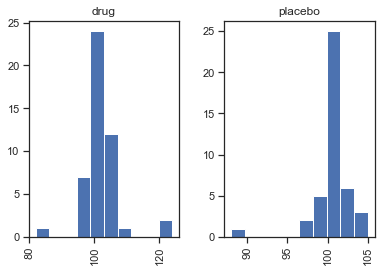

In [52]:
trial_data = pd.concat([drug, placebo], ignore_index=True)
trial_data.hist('iq', by='group')

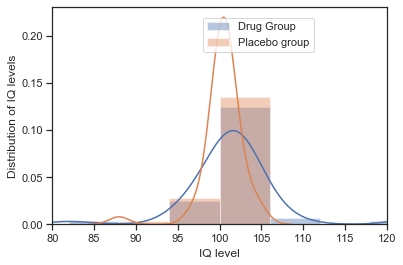

In [53]:
# Let's visualize the data with seaborn, which also gives us a kde estimate
import matplotlib as plt
%matplotlib inline
import seaborn as sns
sns.set(style="ticks")

bins = np.arange(70,150,6)

A = drug.iq.values
B = placebo.iq.values

# Show the results of a linear regression within each dataset
ax1 = sns.distplot(A,bins=bins,label='Drug Group')
ax2 = sns.distplot(B,bins=bins,label='Placebo group')

plt.pyplot.xlabel('IQ level')
plt.pyplot.ylabel('Distribution of IQ levels')
plt.pyplot.legend(bbox_to_anchor=(0.45, 0.95), loc=2, borderaxespad=0.)

plt.pyplot.xlim((80,120))
plt.pyplot.show()

Can you conclude? A bit tough, right?

In [31]:
# packing the data into a tidy dataframe can be nice
exp_df = pd.DataFrame(dict(group=[0]*len(drug.iq)+[1]*len(placebo.iq), score=np.r_[drug.iq,placebo.iq]))

exp_df.head()

,group,score
0,0,101
1,0,100
2,0,102
3,0,104
4,0,102


Can you conclude? A bit tough, right?

In [54]:
import scipy.stats as stats
combined_iq = np.concatenate((drug.iq, placebo.iq))
print(len(drug.iq))
print(len(placebo.iq))
print( drug.iq.mean() )
print( placebo.iq.mean() )
print( drug.iq.var() )
print( placebo.iq.var() )
print( combined_iq.mean() )
stats.ttest_ind(a= drug.iq,
                b= placebo.iq,
                equal_var=False) 

47
42
101.91489361702128
100.35714285714286
36.253469010175756
6.332752613240419
101.17977528089888


Ttest_indResult(statistic=1.622190457290228, pvalue=0.10975381983712831)

The results show that the t-value for the mean difference is 1.622. The p-value is 0.11 which is greater than the traditional "alpha" cut off at p=0.05. Therefore this test is *not significant*: The null hypothesis is in effect.

The test yields a p-value of 0.11 means ***there is a 11% chance we'd see sample data this far apart statistically if the two groups tested are actually identical***. 

If we were using a 95% confidence level, we would **fail** to reject the null hypothesis, since the p-value is greater than the corresponding significance level of 0.05. And so we conclude that the drug is as effective as placebo at a 95% confidence level: there is nothing interesting going on. At a significance level of 0.05, our drug outcome on IQ is statistically **nonsignificant**.

Is the mean of the drug group different than the mean of the placebo group?

In [55]:
print("Mean of drug group:", drug.iq.mean())
print("Mean of placebo group:", placebo.iq.mean())
print("The difference in means is: ", drug.iq.mean()-placebo.iq.mean())

Mean of drug group: 101.91489361702128
Mean of placebo group: 100.35714285714286
The difference in means is:  1.5577507598784166


# 4. Computational Statistics to the Rescue
The best way to evaluate differences between groups it do dump the hypothesis testing framework all together and use Bayesian estimation of the differences between groups. 

Kruschke (2013) describes a simplified/standardize work flow called the BEST test 
(Bayesian ESTimation) although I've also heard it call the *Bayesian Estimation Superceeds the T-test*!.

It's *cheating* because it does all the mcmc work for you. Hust like scipy's `fit` API does all the MLE math for you.

Professors *hate* these APIs when their students use them, but they *love* these APIs when they use them themselves!

[BEST](https://best.readthedocs.io/en/latest/) is a simplified python package that implements this test for you!
```
pip install best
```

In [56]:
import best
est_out = best.analyze_two(drug.iq, placebo.iq, tune = 2000, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Group 2 log sigma, Group 1 log sigma, nu - 2.5, Group 2 mean, Group 1 mean]
Sampling chain 1, 0 divergences: 100%|██████████| 4000/4000 [00:11<00:00, 336.80it/s]


 to find the probability that the first group’s mean is larger by at least 0.5 than the other’s:

In [60]:
est_out.posterior_prob('Difference of means', low=0.5)

0.856

Ok, it's not the $1$ we got with our own analysis, but not far...

In [61]:
est_out.model

BestModelTwo(y1=array([101, 100, 102, 104, 102,  97, 105, 105,  98, 101, 100, 123, 105,
       103, 100,  95, 102, 106, 109, 102,  82, 102, 100, 102, 102, 101,
       102, 102, 103, 103,  97,  97, 103, 101,  97, 104,  96, 103, 124,
       101, 101, 100, 101, 101, 104, 100, 101], dtype=int64), y2=array([ 99, 101, 100, 101, 102, 100,  97, 101, 104, 101, 102, 102, 100,
       105,  88, 101, 100, 104, 100, 100, 100, 101, 102, 103,  97, 101,
       101, 100, 101,  99, 101, 100, 100, 101, 100,  99, 101, 100, 102,
        99, 100,  99], dtype=int64), version='v2')

In [62]:
est_out.trace

<MultiTrace: 2 chains, 2000 iterations, 16 variables>

The 95% highest posterior density interval (HDI) can be queried for:

In [63]:
est_out.hdi('Difference of means', 0.95)

(0.05995531069005722, 1.8861113829038345)

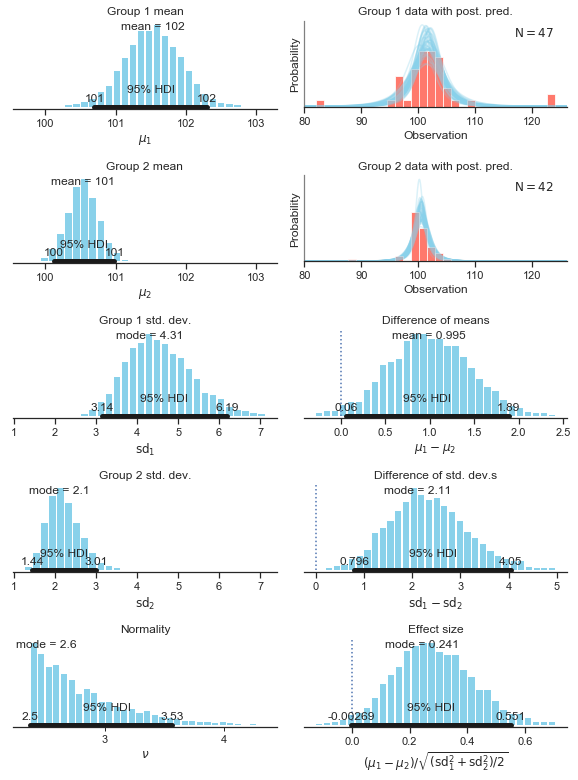

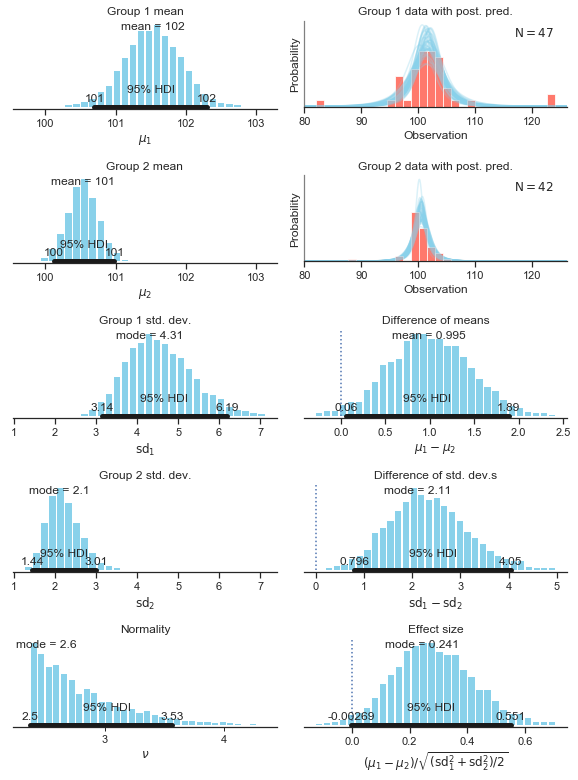

In [64]:
best.plot_all(est_out)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

So, it feels a bit like cheating, but it's a good first step, givinf us an *idea* before we implement our own analysis!

>**Note**: Of course, BEST implements a T-test, which means it uses a Student-T data likelihood. Keep that in mind because oftentimes, the data likelhood is not gaussian-like!

# 5. Built-in Hypothesis Tests with `Pingouin`
[pingouin](https://pingouin-stats.org/) is an open-source statistical package written in Python 3 and based mostly on Pandas and NumPy. It includes a whole suite of classical Hypothesis Tests.
```
pip install pingouin
```

In [65]:
# basic datascience/data manipulation libraries
import numpy as np
import pandas as pd
import numpy.random as npr
import scipy.stats as stats

# graphs
import seaborn as sns
import matplotlib.pyplot as plt

# formulat interface to statsmodels (standard linear models)
import statsmodels.formula.api as smf

# easy-to-use traditional stats
import pingouin as pg

## Two-group independent samples t-test (Student test)
Is the mean of the drug group different than the mean of the placebo group?

In [66]:
print("Mean of drug group:", drug.mean())
print("Mean of placebo group:", placebo.mean())
print("The difference in means is: ", drug.mean()-placebo.mean())

Mean of drug group: iq    101.914894
dtype: float64
Mean of placebo group: iq    100.357143
dtype: float64
The difference in means is:  iq    1.557751
dtype: float64


The look close but not identical.  However, "look" isn't enough.

Lets begin with a two-sample, independent samples t-test.  We will assume that both groups have equal variance here.

In [67]:
drug = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])
placebo = np.array([99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99])


# packing the data into a tidy dataframe can be nice
exp_df = pd.DataFrame(dict(group=[0]*len(drug)+[1]*len(placebo), score=np.r_[drug,placebo]))

exp_df.head()

,group,score
0,0,101
1,0,100
2,0,102
3,0,104
4,0,102


In [68]:
pg.ttest(x=drug, y=placebo,paired=False, tail='two-sided', correction=False)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.558695,87,two-sided,0.122699,"[-0.43, 3.54]",0.330965,0.642,0.338035


We specified group `x` as `drug` and `y` as `placebo` (arbitrarily, you could flip that).  We used 'two-sided' which is the traditionally more conservative test which you use unless you have a strong a-priori belief one group is going to have a higher mean value.  We did not apply a correction known as the Welch-Satterthwaite correction for unequal variances.  We will try that later.

The results show that the t-value for the mean difference is 1.599.  The test has 87 degrees of freedom.  The p-value is 0.122699 which is greater than the traditional "alpha" cut off at p=0.05.  Therefore this test is not significant.  The 95% confidence interval for the differences between the means is -0.43 on the low end to 3.54 with (1.5577 the center).  The effect size (Cohen's d) is 0.331.  The Bayes Factor in favor of the alternative hypothesis (that the means are difference) is lower than one (0.642).  The post-hoc power of the test is 0.338. 

All of this is consistent with there being basically no differences between these two groups.

>**Conclusion**: We conducted an independent sample t-test comparing the mean score in the drug and placebo group which failed to detect a  significant difference ($t(87)=1.56, p=0.12, d=0.331$)

## Two Group Independent Samples unequal variance (Welch test)

The assumption in the previous example was that the standard deviation of the data in the two groups was identical.  This assumption may be inappropriate.  To do a test where this is relaxed is not longer technically a t-test but a [Welch test](https://en.wikipedia.org/wiki/Welch%27s_t-test).   All we do is test correction to `True`:

In [46]:
pg.ttest(x=drug, y=placebo, paired=False, tail='two-sided', correction=True)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,1.62219,63.038897,two-sided,0.109754,"[-0.36, 3.48]",0.330965,0.701,0.338035


There can be some strong arguments that this should be the preferred indendent sample t-test because the assumption of equal variance is unlikely to be met.

>**Conclusion**: We conducted an independent sample Welch test comparing the mean score in the drug and placebo group which failed to detect a  significant difference ($t(63.04)=1.622, p=0.11, d=0.331$)

## Paired samples t-test
In the previous example the two groups were necessarily measuring different individuals (placebo versus a drug study).  However sometimes we measure the same person twice (pre-test, post-test) for instance.  In that case we use the "paired" samples t-test because there is a natural link between individual numbers in both groups (usually a person or some other unit of measurement).

To perform this test we are going to create slightly different data set but you could copy-paste numbers into the `test_1` and `test_2` arrays as in the example above.

In [47]:
test_1 = np.array([101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101])
test_2 = test_1 + npr.normal(loc=2, scale=10, size=len(test_1))


# packing the data into a tidy dataframe can be nice
exp_df = pd.DataFrame(dict(group=[0]*len(test_1)+[1]*len(test_2), score=np.r_[test_1, test_2]))

exp_df.head()

,group,score
0,0,101.0
1,0,100.0
2,0,102.0
3,0,104.0
4,0,102.0


To perform this test we set `paired` to `True`.

In [48]:
pg.ttest(x=test_1, y=test_2,paired=True, tail='two-sided')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-2.887545,46,two-sided,0.005899,"[-7.58, -1.35]",0.454183,6.066,0.861733


>**Conclusion**: We conducted a paired t-test comparing the scores in the first and second test which was significant ($t(46)=3.3, p<.002, d=0.547$).

## One sample t-test
What if you only have one sample and you just want to test if it is different than some specific "null" hypothesis.  For instance many of the scores seem to be about 100 in the `drug` group from the dataset above so we could test the hypothesis "is the mean of that group significantly different than 100?".  A one-sample t-test is appropriate for this:

In [49]:
pg.ttest(x=drug, y=100, paired=True, tail='two-sided')

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,2.180313,46,two-sided,0.034387,"[100.15, 103.68]",0.318031,1.36,0.56936


>**Conclusion**: We conducted a one-sample t-test comparing the scores in the drug group against the null hypothesis of a mean of 100 which did not reach significance ($t(46)=2.18, p=.034, d=0.318$).

## Non-normal data (Wilcoxon or Mann-Whitney test)
All the tests above assume the data is normally distributed (even for the Student-T distribution, we say the data is normally distributed, with many outliers).  But we can't just assume that.  How do you know for sure?  Well it is a bit of a longer topic but there are tests for [non-normality](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3693611/).  

In cases where there is strong suspicion your data are not normally distributed in one or the other group you can use a non-parametric test known as the Wilcoxon (paired samples/within subject) or Mann-Whitney (independent samples) test.  It also exists in `pingouin`:

In [50]:
pg.mwu(x=drug, y=placebo, tail='two-sided')

,U-val,tail,p-val,RBC,CLES
MWU,1267.5,two-sided,0.019609,-0.284195,0.642097


>**Conclusion**: Since our data were non-normal, we conducted a two-side Mann-Whitney test comparing the scores in the drug group against the placebo group which was significant ($U=1267.5, p<.02$).

Although there are may libraries that simplify classical hypothesis testing, I think the best way to evaluate differences between groups is to dump hypothesis testing all together and use Bayesian estimation of the differences between groups. 

# Conclusion
Programming packages like `Scipy` or `BEST` are awesome because thye do all the work for us.

But of course, just like autopilots on commercial airplanes, they *expect* certain conditions (like windspeed, weather, etc., i.e. data likelihood, etc.) to be *normal*.

The moment they are not, the plane crashes and everyone dies.

In your case, you make wrong predictions and your company fires you.

So yeah, use the autopilot, but also invest time in flying manually (i.e. learning the math and doing the coding).

And *don't* tell your interiewer that classical statistics suck, because they may not be a coder!

Also, don't forget that computational statistics require a *lot more* data than mathematicsl methods like MLE. So there are cases where you actually don't have a choice.